# <center> Imports <center>

In [37]:
import time

In [38]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchsummary import summary

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,classification_report
from tqdm.notebook import tqdm

# <center> Hyperparameters <center>

In [40]:
training_path = './Training'
testing_path = './Testing'

IMAGE_SIZE=(128,128)
batch_size=64
learning_rate = 0.0008
epochs=100
num_classes=4 #glioma, meningioma, pituitary, no

device = torch.device('cuda')

# <center> Loading Data <center>

In [41]:
def images_transforms(phase):
    if phase == 'training':
        data_transformation = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
#             transforms.RandomEqualize(10),
            transforms.RandomRotation(degrees=(-25,20)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        data_transformation=transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    
    return data_transformation

In [42]:
trainset=datasets.ImageFolder(training_path,transform=images_transforms('training'))
testset=datasets.ImageFolder(testing_path,transform=images_transforms('test'))
testset, valset = torch.utils.data.random_split(testset, [150, 244])

In [43]:
train_loader = DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
test_loader = DataLoader(testset,batch_size=batch_size,shuffle=True,num_workers=2)
val_loader = DataLoader(valset,batch_size=batch_size,shuffle=True,num_workers=2)

# <center> Visualization <center>

In [44]:
def imshow(img):
    plt.figure(figsize=(20, 20))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


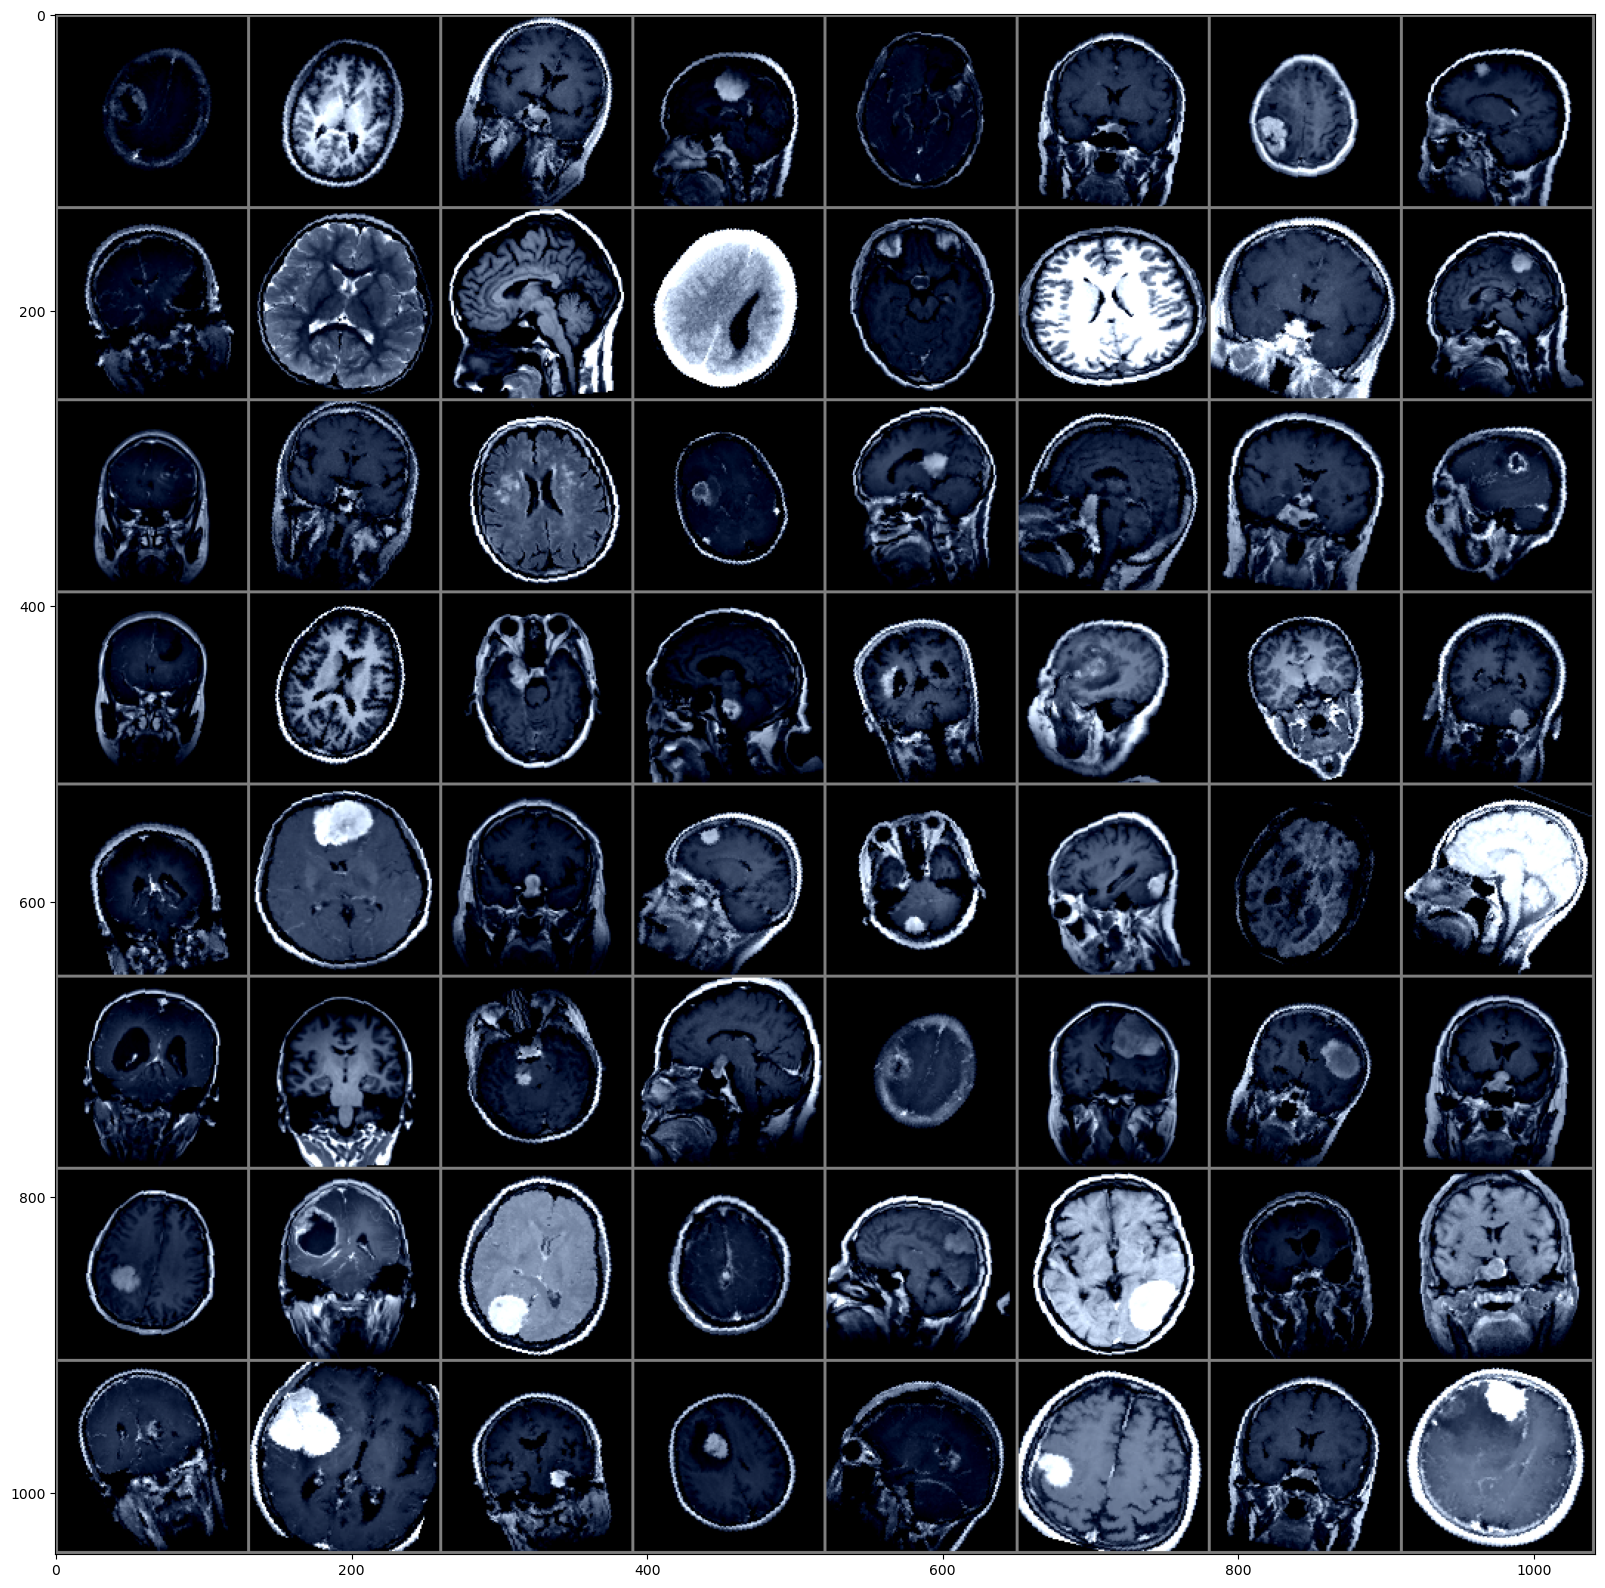

In [45]:
examples = iter(train_loader)
images,labels = next(examples)
imshow(torchvision.utils.make_grid(images))

# <center>Model Creation and Initialization<center>

In [46]:
model=torchvision.models.mobilenet_v3_large(pretrained=True)
num_features=model.classifier[0].in_features
model.classifier=nn.Sequential(
    nn.Linear(in_features=num_features, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=num_classes, bias=True)
  )

C:\Users\Arijit Ghosh\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Arijit Ghosh\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),lr=learning_rate)

# <center>Model Visualization<center>

In [48]:
IMAGE_SIZE=(3,)+IMAGE_SIZE
print(summary(model,IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             432
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         Hardswish-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]             144
       BatchNorm2d-5           [-1, 16, 64, 64]              32
              ReLU-6           [-1, 16, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             256
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]           1,024
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 32, 32]             576
      BatchNorm2d-14           [-1, 64,

# <center> Model Training <center>

In [49]:
def test(model,testloader):
    with torch.no_grad():
        n_correct=0
        n_samples=0
        y_pred=[]
        y_actual=[]
        for i,(images,labels) in enumerate(testloader):
            images=images.to(device)
            labels=labels.to(device)
            
            outputs=model(images)
            
            y_actual+=list(np.array(labels.detach().to('cpu')).flatten())
        # value ,index
            _,predictes=torch.max(outputs,1)
            y_pred+=list(np.array(predictes.detach().to('cpu')).flatten())
        # number of samples in current batch
            n_samples+=labels.shape[0]

            n_correct+= (predictes==labels).sum().item()
            
        y_actual=np.array(y_actual).flatten()
        y_pred=np.array(y_pred).flatten()
        print(np.unique(y_pred))
        acc = classification_report(y_actual,y_pred,target_names=trainset.classes)
        print(f"{acc}")

def train(model,train_loader,criterion,optimizer,val_loader,epochs=25):
    train_losses = []
    val_losses = []
    train_auc = []
    val_auc = []
    train_auc_epoch = []
    val_auc_epoch = []
    best_acc = 0.0
    min_loss = np.Inf

    since = time.time()
    y_actual=[]
    y_pred=[]
    for e in range(epochs):
        y_actual=[]
        y_pred=[]
        train_loss = 0.0
        val_loss = 0.0

        # Train the model
        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy
            train_loss += loss.item()
            
            _,predictes=torch.max(outputs,1)
            y_actual += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        train_auc.append(accuracy_score(y_actual, y_pred))

        # Evaluate the model
        model.eval()
        for i, (images, labels) in enumerate(tqdm(val_loader, total=int(len(val_loader)))):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Loss and accuracy
            val_loss += loss.item()
            _,predictes=torch.max(outputs,1)
            y_actual += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        
        val_auc.append(accuracy_score(y_actual, y_pred))

        # Average losses and accuracies
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        training_auc = train_auc[-1]
        validation_auc = val_auc[-1]
        train_auc_epoch.append(training_auc)
        val_auc_epoch.append(validation_auc)

        # Updating best validation accuracy
        if best_acc < validation_auc:
            best_acc = validation_auc

        # Saving best model
        if min_loss >= val_loss:
            torch.save(model.state_dict(), 'best_model.pt')
            min_loss = val_loss

        print('EPOCH {}/{} Train loss: {:.6f},Validation loss: {:.6f}, Train AUC: {:.4f}  Validation AUC: {:.4f}\n  '.format(e+1, epochs,train_loss,val_loss, training_auc,validation_auc))
        print('-' * 10)
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(best_acc))
    return train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch

In [50]:
train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch=train(model,train_loader,criterion,optimizer,val_loader,epochs)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 1/100 Train loss: 0.563295,Validation loss: 1.110460, Train AUC: 0.7742  Validation AUC: 0.7572
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 2/100 Train loss: 0.199973,Validation loss: 1.254955, Train AUC: 0.9293  Validation AUC: 0.9059
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 3/100 Train loss: 0.127289,Validation loss: 1.426132, Train AUC: 0.9526  Validation AUC: 0.9294
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 4/100 Train loss: 0.079393,Validation loss: 1.570849, Train AUC: 0.9707  Validation AUC: 0.9473
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 5/100 Train loss: 0.052888,Validation loss: 1.723627, Train AUC: 0.9819  Validation AUC: 0.9583
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 6/100 Train loss: 0.051115,Validation loss: 1.534453, Train AUC: 0.9829  Validation AUC: 0.9615
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 7/100 Train loss: 0.027367,Validation loss: 1.930617, Train AUC: 0.9899  Validation AUC: 0.9650
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 8/100 Train loss: 0.027156,Validation loss: 1.930954, Train AUC: 0.9909  Validation AUC: 0.9647
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 9/100 Train loss: 0.020709,Validation loss: 1.962588, Train AUC: 0.9923  Validation AUC: 0.9672
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 10/100 Train loss: 0.041460,Validation loss: 1.572439, Train AUC: 0.9864  Validation AUC: 0.9647
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 11/100 Train loss: 0.021586,Validation loss: 1.902587, Train AUC: 0.9934  Validation AUC: 0.9740
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 12/100 Train loss: 0.014265,Validation loss: 1.825186, Train AUC: 0.9951  Validation AUC: 0.9769
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 13/100 Train loss: 0.021500,Validation loss: 1.558547, Train AUC: 0.9923  Validation AUC: 0.9746
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 14/100 Train loss: 0.019462,Validation loss: 1.607773, Train AUC: 0.9927  Validation AUC: 0.9753
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 15/100 Train loss: 0.020526,Validation loss: 2.075110, Train AUC: 0.9923  Validation AUC: 0.9743
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 16/100 Train loss: 0.012167,Validation loss: 1.898890, Train AUC: 0.9955  Validation AUC: 0.9778
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 17/100 Train loss: 0.011357,Validation loss: 2.310373, Train AUC: 0.9962  Validation AUC: 0.9782
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 18/100 Train loss: 0.007617,Validation loss: 2.296810, Train AUC: 0.9965  Validation AUC: 0.9782
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 19/100 Train loss: 0.008668,Validation loss: 2.346283, Train AUC: 0.9976  Validation AUC: 0.9801
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 20/100 Train loss: 0.015151,Validation loss: 2.248083, Train AUC: 0.9948  Validation AUC: 0.9766
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 21/100 Train loss: 0.021864,Validation loss: 2.142718, Train AUC: 0.9937  Validation AUC: 0.9759
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 22/100 Train loss: 0.013865,Validation loss: 2.359372, Train AUC: 0.9958  Validation AUC: 0.9775
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 23/100 Train loss: 0.009809,Validation loss: 2.351808, Train AUC: 0.9965  Validation AUC: 0.9788
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 24/100 Train loss: 0.007764,Validation loss: 2.163378, Train AUC: 0.9972  Validation AUC: 0.9794
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 25/100 Train loss: 0.002992,Validation loss: 2.381851, Train AUC: 0.9993  Validation AUC: 0.9823
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 26/100 Train loss: 0.006279,Validation loss: 2.272956, Train AUC: 0.9986  Validation AUC: 0.9817
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 27/100 Train loss: 0.002972,Validation loss: 2.655806, Train AUC: 0.9986  Validation AUC: 0.9807
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 28/100 Train loss: 0.001637,Validation loss: 2.706148, Train AUC: 0.9997  Validation AUC: 0.9817
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 29/100 Train loss: 0.007821,Validation loss: 2.656806, Train AUC: 0.9969  Validation AUC: 0.9788
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 30/100 Train loss: 0.003336,Validation loss: 2.876732, Train AUC: 0.9990  Validation AUC: 0.9801
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 31/100 Train loss: 0.005617,Validation loss: 2.760601, Train AUC: 0.9976  Validation AUC: 0.9794
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 32/100 Train loss: 0.001797,Validation loss: 2.963323, Train AUC: 0.9993  Validation AUC: 0.9804
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 33/100 Train loss: 0.001799,Validation loss: 3.327959, Train AUC: 0.9997  Validation AUC: 0.9804
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 34/100 Train loss: 0.001714,Validation loss: 2.852222, Train AUC: 0.9993  Validation AUC: 0.9807
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 35/100 Train loss: 0.005158,Validation loss: 3.011954, Train AUC: 0.9983  Validation AUC: 0.9804
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 36/100 Train loss: 0.020456,Validation loss: 2.953826, Train AUC: 0.9948  Validation AUC: 0.9772
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 37/100 Train loss: 0.002607,Validation loss: 2.811995, Train AUC: 0.9990  Validation AUC: 0.9804
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 38/100 Train loss: 0.004465,Validation loss: 2.470352, Train AUC: 0.9979  Validation AUC: 0.9798
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 39/100 Train loss: 0.007216,Validation loss: 2.709205, Train AUC: 0.9976  Validation AUC: 0.9785
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 40/100 Train loss: 0.003104,Validation loss: 2.556972, Train AUC: 0.9990  Validation AUC: 0.9801
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 41/100 Train loss: 0.001723,Validation loss: 2.338492, Train AUC: 0.9990  Validation AUC: 0.9804
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 42/100 Train loss: 0.000886,Validation loss: 2.314100, Train AUC: 1.0000  Validation AUC: 0.9820
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 43/100 Train loss: 0.005072,Validation loss: 2.428374, Train AUC: 0.9990  Validation AUC: 0.9811
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 44/100 Train loss: 0.000790,Validation loss: 2.472067, Train AUC: 1.0000  Validation AUC: 0.9823
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 45/100 Train loss: 0.003324,Validation loss: 2.538646, Train AUC: 0.9986  Validation AUC: 0.9794
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 46/100 Train loss: 0.001451,Validation loss: 2.529859, Train AUC: 0.9997  Validation AUC: 0.9801
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 47/100 Train loss: 0.002289,Validation loss: 2.906616, Train AUC: 0.9990  Validation AUC: 0.9798
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 48/100 Train loss: 0.013544,Validation loss: 2.478568, Train AUC: 0.9969  Validation AUC: 0.9785
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 49/100 Train loss: 0.002832,Validation loss: 2.847312, Train AUC: 0.9990  Validation AUC: 0.9807
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 50/100 Train loss: 0.004746,Validation loss: 2.627226, Train AUC: 0.9997  Validation AUC: 0.9817
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 51/100 Train loss: 0.003171,Validation loss: 2.830751, Train AUC: 0.9986  Validation AUC: 0.9811
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 52/100 Train loss: 0.002818,Validation loss: 3.011826, Train AUC: 0.9986  Validation AUC: 0.9811
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 53/100 Train loss: 0.004009,Validation loss: 3.103345, Train AUC: 0.9990  Validation AUC: 0.9807
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 54/100 Train loss: 0.000550,Validation loss: 3.129143, Train AUC: 1.0000  Validation AUC: 0.9817
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 55/100 Train loss: 0.000917,Validation loss: 3.178495, Train AUC: 0.9997  Validation AUC: 0.9811
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 56/100 Train loss: 0.001072,Validation loss: 3.191516, Train AUC: 0.9997  Validation AUC: 0.9811
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 57/100 Train loss: 0.004480,Validation loss: 2.704289, Train AUC: 0.9990  Validation AUC: 0.9804
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 58/100 Train loss: 0.005411,Validation loss: 2.997550, Train AUC: 0.9986  Validation AUC: 0.9788
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 59/100 Train loss: 0.001449,Validation loss: 3.292293, Train AUC: 0.9997  Validation AUC: 0.9798
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 60/100 Train loss: 0.004933,Validation loss: 3.310126, Train AUC: 0.9990  Validation AUC: 0.9794
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 61/100 Train loss: 0.000574,Validation loss: 2.935498, Train AUC: 0.9997  Validation AUC: 0.9798
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 62/100 Train loss: 0.000282,Validation loss: 3.028172, Train AUC: 1.0000  Validation AUC: 0.9801
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 63/100 Train loss: 0.004611,Validation loss: 3.270475, Train AUC: 0.9993  Validation AUC: 0.9794
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 64/100 Train loss: 0.014028,Validation loss: 3.278097, Train AUC: 0.9955  Validation AUC: 0.9762
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 65/100 Train loss: 0.006193,Validation loss: 2.896826, Train AUC: 0.9983  Validation AUC: 0.9804
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 66/100 Train loss: 0.007139,Validation loss: 2.753966, Train AUC: 0.9986  Validation AUC: 0.9807
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 67/100 Train loss: 0.003898,Validation loss: 2.988328, Train AUC: 0.9990  Validation AUC: 0.9811
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 68/100 Train loss: 0.006175,Validation loss: 2.785379, Train AUC: 0.9983  Validation AUC: 0.9807
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 69/100 Train loss: 0.004887,Validation loss: 2.496065, Train AUC: 0.9983  Validation AUC: 0.9811
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 70/100 Train loss: 0.010912,Validation loss: 3.271804, Train AUC: 0.9972  Validation AUC: 0.9762
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 71/100 Train loss: 0.000690,Validation loss: 3.219006, Train AUC: 1.0000  Validation AUC: 0.9791
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 72/100 Train loss: 0.005091,Validation loss: 3.231394, Train AUC: 0.9979  Validation AUC: 0.9782
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 73/100 Train loss: 0.005719,Validation loss: 3.027344, Train AUC: 0.9986  Validation AUC: 0.9798
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 74/100 Train loss: 0.000846,Validation loss: 3.119625, Train AUC: 0.9997  Validation AUC: 0.9801
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 75/100 Train loss: 0.001857,Validation loss: 3.017538, Train AUC: 0.9997  Validation AUC: 0.9788
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 76/100 Train loss: 0.002774,Validation loss: 2.983354, Train AUC: 0.9990  Validation AUC: 0.9801
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 77/100 Train loss: 0.002668,Validation loss: 2.919374, Train AUC: 0.9993  Validation AUC: 0.9794
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 78/100 Train loss: 0.000238,Validation loss: 2.941032, Train AUC: 1.0000  Validation AUC: 0.9801
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 79/100 Train loss: 0.000128,Validation loss: 2.985955, Train AUC: 1.0000  Validation AUC: 0.9801
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 80/100 Train loss: 0.001179,Validation loss: 3.090567, Train AUC: 0.9993  Validation AUC: 0.9804
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 81/100 Train loss: 0.005558,Validation loss: 2.803054, Train AUC: 0.9993  Validation AUC: 0.9804
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 82/100 Train loss: 0.002176,Validation loss: 2.853094, Train AUC: 0.9997  Validation AUC: 0.9804
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 83/100 Train loss: 0.001131,Validation loss: 2.988907, Train AUC: 0.9997  Validation AUC: 0.9798
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 84/100 Train loss: 0.000979,Validation loss: 2.787648, Train AUC: 0.9997  Validation AUC: 0.9807
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 85/100 Train loss: 0.004687,Validation loss: 2.740792, Train AUC: 0.9983  Validation AUC: 0.9794
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 86/100 Train loss: 0.001840,Validation loss: 2.853189, Train AUC: 0.9993  Validation AUC: 0.9807
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 87/100 Train loss: 0.005044,Validation loss: 2.947304, Train AUC: 0.9986  Validation AUC: 0.9801
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 88/100 Train loss: 0.007375,Validation loss: 2.457561, Train AUC: 0.9993  Validation AUC: 0.9827
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 89/100 Train loss: 0.002216,Validation loss: 2.931641, Train AUC: 0.9993  Validation AUC: 0.9820
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 90/100 Train loss: 0.002561,Validation loss: 2.523558, Train AUC: 0.9986  Validation AUC: 0.9820
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 91/100 Train loss: 0.001579,Validation loss: 2.714704, Train AUC: 0.9993  Validation AUC: 0.9814
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 92/100 Train loss: 0.005350,Validation loss: 2.634234, Train AUC: 0.9979  Validation AUC: 0.9794
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 93/100 Train loss: 0.000785,Validation loss: 2.740918, Train AUC: 0.9997  Validation AUC: 0.9814
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 94/100 Train loss: 0.011309,Validation loss: 3.056255, Train AUC: 0.9972  Validation AUC: 0.9775
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 95/100 Train loss: 0.001594,Validation loss: 2.642608, Train AUC: 0.9993  Validation AUC: 0.9807
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 96/100 Train loss: 0.004239,Validation loss: 2.683825, Train AUC: 0.9990  Validation AUC: 0.9807
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 97/100 Train loss: 0.005393,Validation loss: 2.605006, Train AUC: 0.9993  Validation AUC: 0.9811
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 98/100 Train loss: 0.005261,Validation loss: 2.813487, Train AUC: 0.9986  Validation AUC: 0.9801
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 99/100 Train loss: 0.003385,Validation loss: 2.976359, Train AUC: 0.9990  Validation AUC: 0.9811
  
----------


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH 100/100 Train loss: 0.003179,Validation loss: 2.791910, Train AUC: 0.9990  Validation AUC: 0.9814
  
----------
Training completed in 16m 22s
Best validation accuracy: 0.982659


# <center> Model Evaluation <center>

In [51]:
# model.load_state_dict(torch.load('../working/best_model.pt'))
test(model,test_loader)

[0 1 2 3]
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.21      0.35        42
meningioma_tumor       0.60      1.00      0.75        40
        no_tumor       0.80      1.00      0.89        41
 pituitary_tumor       0.91      0.78      0.84        27

        accuracy                           0.74       150
       macro avg       0.83      0.75      0.71       150
    weighted avg       0.82      0.74      0.69       150



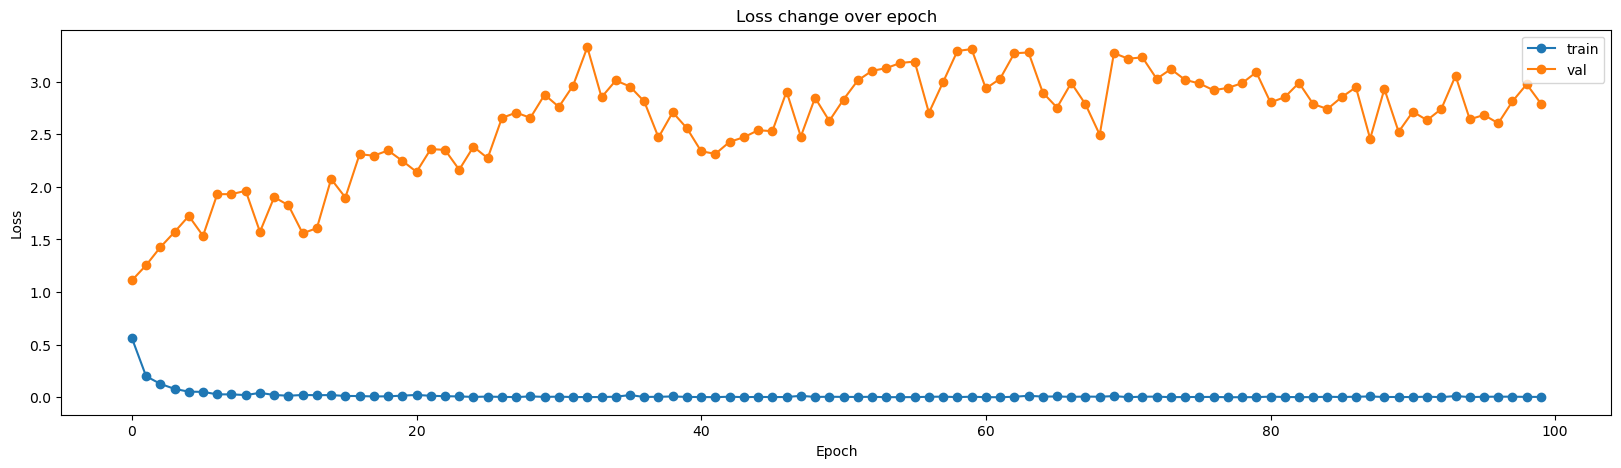

In [52]:
plt.figure(figsize=(20,5))
plt.plot(train_losses, '-o', label="train")
plt.plot(val_losses, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss change over epoch")
plt.legend()

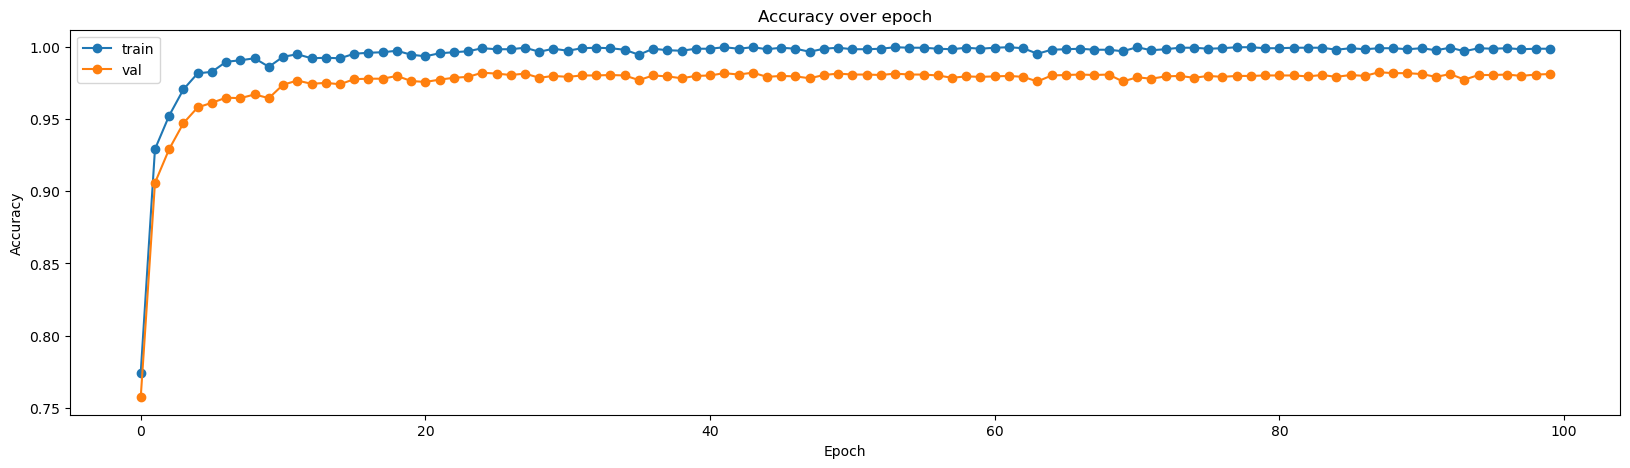

In [53]:
plt.figure(figsize=(20,5))
plt.plot(train_auc_epoch, '-o', label="train")
plt.plot(val_auc_epoch, '-o', label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epoch")
plt.legend()